In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
from sensor import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
#%matplotlib notebook

In [2]:
class Dstar():
    def __init__(
        self, world, sensor,
        drawCost_flag=False, drawPathToTake_flag=True, drawTakenPath_flag=True, drawMetricMap_flag=False
    ):
        self.world = world
        self.real_grid_map = world.grid_map #実際のマップ
        self.sensor = sensor
        
        self.flag_path_draw = 0  #経路描画のフラグ
        self.drawCost_flag = drawCost_flag
        self.drawPathToTake_flag = drawPathToTake_flag
        self.drawTakenPath_flag = drawTakenPath_flag
        self.drawMetricMap_flag = drawMetricMap_flag
        self.pp_algorithm_name = "Dstar"
        
        self.initialize()
        
    def initialize(self):
        self.metric_grid_map = np.full(self.world.grid_map.shape, -1)  #測定により得られたマップ
        self.cost_map = np.full(self.world.grid_map.shape, 1)    #その地点が持つコスト
        self.id_map = np.full(self.world.grid_map.shape, 0)
        self.child_id_map = np.full(self.world.grid_map.shape, 0)
        self.open_list = []
        self.closed_list = []
        self.pathToTake = []   #今後の経路
        self.takenPath = []
        self.newObstaces = []
        self.h_map = np.full(self.world.grid_map.shape, 10000.0)
        self.k_map = np.full(self.world.grid_map.shape, 10000.0)
        self.currentIndex = self.world.start_index
        
        #各グリッドのIDを登録，ゴール地点のコストを決定
        grid_id = 0
        for index, grid in np.ndenumerate(self.real_grid_map):
            self.id_map[index[0]][index[1]] = grid_id
            if(grid == '3' or self.world.isGoal(index)):
                self.h_map[index[0]][index[1]] = 0
                self.k_map[index[0]][index[1]] = 0
                self.openAppend(index, 0)
            elif(grid == "2" or self.world.isStart(index)):
                self.metric_grid_map[index[0]][index[1]] = 0
            grid_id += 1
        
        #既知の地図を用いて各グリッドのコストを生成し，経路を生成する
        index = np.array([-1, -1])
        k_min = 0.0
        while(k_min != -1 and self.world.isStart(index)):
            index = self.processState()
            if(np.all(index == [-1, -1])):
                k_min = -1
            else:
                k_min = self.k(index)
        
    def draw(self, ax, elems):
        # Check New Obstacle -> Move to Next Index
        self.checkNewObstacle(self.currentIndex)
        self.currentIndex = self.next(self.currentIndex)
        
        self.getPathToTake(self.currentIndex)
        self.drawNewObstacles(ax, elems) if(not self.drawMetricMap_flag) else None
        self.drawPathToTake(ax, elems) if(self.drawPathToTake_flag) else None
        self.drawCost(ax, elems) if(self.drawCost_flag) else None
        self.drawMetricMap(ax, elems) if(self.drawMetricMap_flag) else None
        self.drawRobot(ax, elems)
    
    def plot(self, figsize=(4, 4), save_path=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.world.grid_map):
            if grid == '0':
                self.world.drawGrid(index, "black", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal
                self.world.drawGrid(index, "green", 1.0, ax)
        
        for index in self.takenPath:
            if (not self.world.isStart(index)) and (not self.world.isGoal(index)):
                self.world.drawGrid(index, "red", 0.5, ax)
        
        plt.show()

        if(save_path is not None):
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        return fig

    def run(self):
        self.initialize()
        while not self.world.isGoal(self.currentIndex):
            self.checkNewObstacle(self.currentIndex)
            self.currentIndex = self.next(self.currentIndex)
            self.takenPath.append(self.currentIndex)
    
    def next(self, index):
        self.updateCost(index)
        next_index = index
        if not self.world.isGoal(index):
            child_id = self.child_id_map[index[0]][index[1]]
            child = np.where(self.id_map==child_id)
            next_index = np.array([int(child[0]), int(child[1])])
        return next_index
    
    def checkNewObstacle(self, index):
        obstacles = self.sensor.sense(index)
        self.newObstacles = [obstacle[0] for obstacle in obstacles]
        for u, occupancy in obstacles:
            prev_u_obs_flag = self.isUnobserved(u)
            self.metric_grid_map[u[0]][u[1]] = occupancy
            if prev_u_obs_flag:  #新しい障害物の場合
                self.insert(u, self.h(u))
                self.h_map[u[0]][u[1]] = 10000  #障害物のコストを無限大にする
                for grid in neigbor_grids:  #周囲のグリッドをオープンリストに追加する
                    neigbor_index = u + grid
                    if self.world.isOutOfBounds(neigbor_index) or self.isObservedObstacle(neigbor_index):
                        continue
                    self.insert(neigbor_index, self.k(neigbor_index))
            
#         for sensing_grid in self.sensing_range: #新しく障害物が見つかったかどうかを確認する
#             sensing_index = currentIndex + sensing_grid
#             if(self.world.isOutOfBounds(sensing_index) or np.all(currentIndex == sensing_index)):
#                 continue
#             if self.isUnobserved(sensing_index):  #まだ探索していないグリッドの場合
#                 self.metric_grid_map[sensing_index[0]][sensing_index[1]] = self.real_grid_map[sensing_index[0]][sensing_index[1]]
#                 if self.isObservedObstacle(sensing_index):  #新しい障害物の場合
#                     self.insert(sensing_index, self.h(sensing_index))
#                     self.h_map[sensing_index[0]][sensing_index[1]] = 10000  #障害物のコストを無限大にする
#                     for adjacent_grid in neigbor_grids:  #周囲のグリッドをオープンリストに追加する
#                         adjacent_index = sensing_index + adjacent_grid
#                         if self.world.isOutOfBounds(adjacent_index):
#                             continue
#                         elif self.isObservedObstacle(adjacent_index): #障害物か
#                             continue
#                         self.insert(adjacent_index, self.k(adjacent_index))
#                     self.newObstacles.append(sensing_index)
    
    def updateCost(self, index):
        k_min = 0.0
        h_now = self.h(index)
        while(k_min != -1 and k_min < h_now):
            index = self.processState()
            if(np.all(index == [-1, -1])):
                k_min = -1
            else:
                k_min = self.k(index)
    
    def getPathToTake(self, currentIndex):
        self.pathToTake = []
        child_id = self.id(currentIndex)
        while(child_id != self.id(self.world.goal_index)):  #ゴールになるまでたどる
            child = np.where(self.id_map==child_id)
            self.pathToTake.append([child[0][0], child[1][0]])
            child_id = self.child_id_map[int(child[0])][int(child[1])]
    
    def processState(self):
        index = self.getMinKGrid()
        if(np.all(index == [-1, -1])):
            return np.array([-1, -1])
        k_old = self.k(index)
        self.closeAppend(index)
        
        if(k_old < self.h(index)):
            for neigbor_grid in neigbor_grids:
                neigbor_index = index + neigbor_grid
                if(self.world.isOutOfBounds(neigbor_index)):
                    continue
                cost_h_new = self.h(neigbor_index) + self.c(index, neigbor_index)
                if(
                    self.isNewGrid(neigbor_index) == False and
                    self.h(neigbor_index) <= k_old and
                    self.isHlarger(self.h(index), cost_h_new)
                ):
                    self.child_id_map[index[0]][index[1]] = self.id(neigbor_index)
                    self.h_map[index[0]][index[1]] = self.h(neigbor_index) + self.c(index, neigbor_index)
        
        if(self.isHsame(k_old, self.h(index))):
            for neigbor_grid in neigbor_grids:
                neigbor_index = index + neigbor_grid
                if(self.world.isOutOfBounds(neigbor_index)):
                    continue
                cost_h_new = self.h(index)+self.c(index, neigbor_index)
                if(
                    self.isNewGrid(neigbor_index) or
                    (self.b(neigbor_index) == self.id(index) and self.isHsame(self.h(neigbor_index), cost_h_new) == False) or
                    (self.b(neigbor_index) != self.id(index) and self.isHlarger(self.h(neigbor_index), cost_h_new))
                ):
                    self.child_id_map[neigbor_index[0]][neigbor_index[1]] = self.id(index)
                    self.insert(neigbor_index, cost_h_new)
        else:
            for neigbor_grid in neigbor_grids:
                neigbor_index = index + neigbor_grid
                if(self.world.isOutOfBounds(neigbor_index)):
                    continue
                cost_h_new = self.h(index) + self.c(index, neigbor_index)
                if(
                    self.isNewGrid(neigbor_index) or
                    (self.b(neigbor_index) == self.id(index) and self.isHsame(self.h(neigbor_index), cost_h_new) == False)
                ):
                    self.child_id_map[neigbor_index[0]][neigbor_index[1]] = self.id(index)
                    self.insert(neigbor_index, cost_h_new)
                elif(
                    self.b(neigbor_index) != self.id(index) and
                    self.isHlarger(self.h(neigbor_index), cost_h_new)
                ):
                    self.insert(index, self.h(index))
                elif(
                    self.b(neigbor_index) != self.id(index) and
                    self.isHlarger(self.h(index), self.h(neigbor_index) + self.c(index, neigbor_index)) and
                    self.isClosedGrid(neigbor_index) and
                    self.h(neigbor_index) > k_old
                ):
                    self.insert(neigbor_index, self.h(neigbor_index))
                else:
                    pass
        index = self.getMinKGrid()
        return index
    
    def insert(self, index, h_new):
        if(h_new > 10000):
            h_new = 10000
        if(self.isNewGrid(index) == True):
            k = h_new
        elif(self.isOpenedGrid(index) == True):
            if(self.k(index) > h_new):
                k = h_new
            else:
                k = self.k(index)
        elif(self.isClosedGrid(index) == True):
            if(self.h(index) > h_new):
                k = h_new
            else:
                k = self.h(index)
        self.openAppend(index, k)
        self.k_map[index[0]][index[1]] = k
        self.h_map[index[0]][index[1]] = h_new
    
    def isOpenedGrid(self, index):
        if(self.id_map[index[0]][index[1]] in [val[0] for val in self.open_list]):
            return True
        else:
            return False
        
    def isClosedGrid(self, index):
        if(self.id_map[index[0]][index[1]] in self.closed_list):
            return True
        else:
            return False
    
    def isNewGrid(self, index):
        if(self.id_map[index[0]][index[1]] in [val[0] for val in self.open_list]):
            return False
        elif(self.id_map[index[0]][index[1]] in self.closed_list):
            return False
        else:
            return True
    
    def openAppend(self, index, cost_k):
        if(self.isOpenedGrid(index) == True):
            if(self.k(index) != cost_k):
                self.open_list.remove([self.id(index), self.k(index)])
                self.open_list.append([self.id(index), cost_k])
            return
        elif(self.isClosedGrid(index) == True):
            self.closed_list.remove(self.id(index))
        self.open_list.append([self.id(index), cost_k])
    
    def closeAppend(self, index):
        if(self.isOpenedGrid(index) == True):
            self.open_list.remove([self.id(index), self.k(index)])
        elif(self.isClosedGrid(index) == True):
            return
        self.closed_list.append(self.id(index))
    
    def getMinKGrid(self):
        if(self.open_list == []):
            return np.array([-1, -1])
        val = np.argmin(self.open_list, axis=0) #評価マップの中から最も小さいもの抽出
        grid_id = self.open_list[val[1]][0]
        index = np.where(self.id_map==grid_id)
        return np.array([index[0][0], index[1][0]])
    
    def isHsame(self, cost_h1, cost_h2):
        if(cost_h1 == cost_h2):
            return True
        else:
            if(cost_h1 >= 10000 and cost_h2 >= 10000):
                return True
            else:
                return False
    
    def isHlarger(self, cost_h1, cost_h2):
        if(cost_h1 >= 10000 and cost_h2 >= 10000):
            return False
        else:
            if(cost_h1 > cost_h2):
                return True
            else:
                return False
    
    def h(self, index):
        return self.h_map[index[0]][index[1]]
        
    def k(self, index):
        return self.k_map[index[0]][index[1]]
    
    def b(self, index):  #子ノードのidを返す
        return self.child_id_map[index[0]][index[1]]
    
    def c(self, index, neigbor_index): #隣接ノードへ移動するのに要するコスト
        if self.isObservedObstacle(index) or self.isObservedObstacle(neigbor_index):
            return 10000
        else:
            return np.linalg.norm(neigbor_index - index)
    
    def id(self, index):
        return self.id_map[index[0]][index[1]]
    
    def isUnobserved(self, index):
        if self.metric_grid_map[index[0]][index[1]] == -1:
            return True
        else:
            return False
    
    def isObservedObstacle(self, index):
        if self.metric_grid_map[index[0]][index[1]] > 0.3:
            return True
        else:
            return False
    
    def drawNewObstacles(self, ax, elems):
        for index in self.newObstacles:
            self.world.drawGrid(index, "black", 1.0, ax, fill=True)
    
    def drawPathToTake(self, ax, elems):
        for n in self.pathToTake:
            self.world.drawGrid(n, "red", 0.5, ax, elems=elems)
    
    def drawRobot(self, ax, elems):
        if self.id(self.currentIndex) != self.id(self.world.start_index) and self.id(self.currentIndex) != self.id(self.world.goal_index):
            self.world.drawGrid(self.currentIndex, "magenta", 0.5, ax) if(self.drawTakenPath_flag) else None
            self.world.drawGrid(self.currentIndex, "blue", 1.0, ax, elems=elems)
    
    def drawCost(self, ax, elems):
        for index, _ in np.ndenumerate(self.metric_grid_map):
            if(self.k(index) < 10000):
                c_num = int(self.k(index)) #Black→Blue
                c_num = int(c_num * 7.5)
                if(c_num > 0xff): #Blue → Cyan
                    c_num = (c_num-0xff)*16*16 + 0xff
                    if(c_num > 0xffff): #Cyan → Green
                        c_num = 0xffff - int((c_num-0x100ff)*4/256)
                        if(c_num < 0xff00): #Green →Yellow
                            c_num = (0xff00-c_num)*65536+0xff00
                            if(c_num > 0xffff00): #Yellow → Red
                                c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
                fill = True
                alpha = 0.5
                c = '#' + format(int(c_num), 'x').zfill(6)
                self.world.drawGrid(index, c, alpha, ax, fill, elems)
            else:
                #RAISE状態のセルを描画
                #self.world.drawGrid(index, "red", 1.0, ax, True, elems)
                continue
                
    def drawMetricMap(self, ax, elems):
        for index, grid in np.ndenumerate(self.metric_grid_map):
            if(grid > 0.3):
                continue
            elif(grid == -1):
                c = "lightgray"
            elif(grid == 0):
                c = "black"
            self.world.drawGrid(index, c, 1.0, ax, elems=elems)
        self.world.drawGrid(self.world.goal_index, "green", 1.0, ax, elems=elems)

<IPython.core.display.Javascript object>


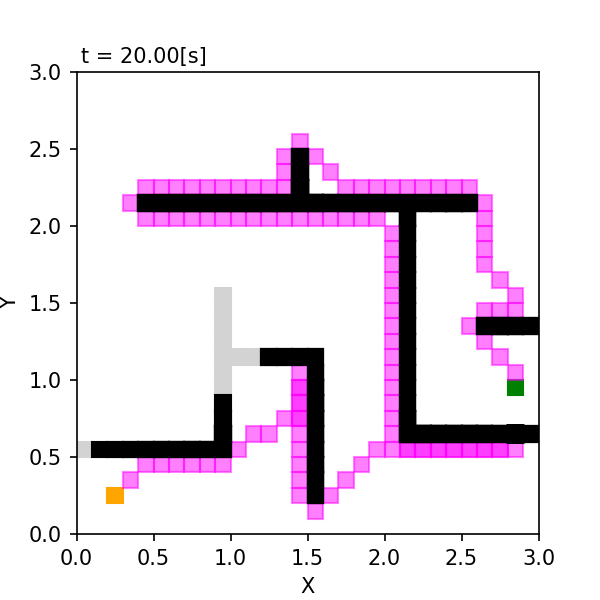

In [3]:
if __name__ == "__main__":
    time_span = 20
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map2.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, time_show="time", debug=False, is_dynamic=True)
    sensor = IdealSensor(world)
    world.append(Dstar(world, sensor))
    
    world.draw()
    #world.ani.save('dstar_map2_cost.gif', writer='pillow', fps=100)    #アニメーション保存